In [ ]:
import torch as t
import numpy as np
from torch.nn.functional import cross_entropy
from einops import rearrange
import days.bert as bert
from days.bert import Bert, my_bert_from_hf_weights
from days.utils import tpeek
import transformers
import torchtext
from datetime import datetime
from torch.optim import Adam
import os
device = "cuda" if t.cuda.is_available() else "cpu"
print("device is", device)
#hello there, I'm a new line
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

device is cuda


In [ ]:
train_data_sentence_iterator = torchtext.datasets.WikiText2(split="train")
train_data = "\n".join(train_data_sentence_iterator).replace("<unk>", "[UNK]")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

tokenizer_output = tokenizer(train_data)
token_ids = t.IntTensor(tokenizer_output["input_ids"])

100%|████████████████████████████████████████████████████████████████████████████████████| 4.48M/4.48M [00:00<00:00, 7.67MB/s]


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2284375 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
def ids_to_strings(tokenizer, ids):
    token_strings = tokenizer.convert_ids_to_tokens(ids)
    token_strings = [tokenizer.convert_tokens_to_string([string]) for string in token_strings]
    return token_strings

def infer_bert(model, tokenizer, text):
    input_ids = t.LongTensor(tokenizer(text).input_ids).unsqueeze(0)
    logits = model(input_ids=input_ids.to(next(model.parameters()).device)).logits.squeeze(0)
    return logits
default_logits = infer_bert(model, tokenizer, "[MASK]")[1]
print(default_logits.shape)
def infer_show_bert(model, tokenizer, text, topk=7, relative=True):
    global default_logits
    tokens = tokenizer(text).input_ids
    mask_idx = tokens.index(tokenizer.mask_token_id)
    logits = infer_bert(model, tokenizer, text)
    if relative:
        logits-= default_logits
    top10 = t.topk(logits[mask_idx],topk).indices
    topk_words = [ids_to_strings(tokenizer, [tok])[0] for tok in top10]
    print(f"{text} <- [{' '.join(topk_words)}]")
def show_bert_texts(model, texts=["The chicken has very beautiful feathers (much better than any macaw!). The chicken crossed the street and got run over by a [MASK]. After that it got reanimated by a wizard, and lived a happy little chicken life for the rest of eternity.", "my name is Amy. Yes, my name is [MASK].", "Hello, my name is [MASK].", "[MASK], my name is Amy.", "I'm going to a restaurant, and then going to [MASK]."]):
    for fun_text in texts:
        infer_show_bert(model, tokenizer, fun_text, relative=False)
show_bert_texts(model)

torch.Size([28996])
The chicken has very beautiful feathers (much better than any macaw!). The chicken crossed the street and got run over by a [MASK]. After that it got reanimated by a wizard, and lived a happy little chicken life for the rest of eternity. <- [the , . and [UNK] in ##ahan]
my name is Amy. Yes, my name is [MASK]. <- [the and , . Love ##lic Colt]
Hello, my name is [MASK]. <- [the , . @ stakes of ##lic]
[MASK], my name is Amy. <- [the , . and of in stakes]
I'm going to a restaurant, and then going to [MASK]. <- [the , . in and stakes [UNK]]


In [ ]:
default_logits = None
from importlib import reload
reload(bert)
train_losses = []
bot_token_id = 101
eot_token_id = 102 # because I say so
def train_from_scratch(model, tokenizer, dataset, epochs=10, lr=2e-5):
    global default_logits
    model.train()
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    num_warmup_steps = 10
    train_context_length = 256
    batch_size = 32
    mask_fraction = 0.2
    trunc_token_ids = token_ids[:(token_ids.shape[0] // (batch_size * (train_context_length-2))) * 
                                  batch_size * (train_context_length-2)]
    print("have token ids")
    batches = rearrange(trunc_token_ids, "(n b l) -> n b l", b=batch_size, l=train_context_length-2)
    batches = batches[t.randperm(batches.shape[0])]
    batches = t.cat([t.LongTensor(*batches.shape[:-1],1).fill_(bot_token_id), 
                     batches, 
                     t.LongTensor(*batches.shape[:-1],1).fill_(eot_token_id)], 
                    dim=2)
    print("batches", batches.shape)
    print_every_n = 50
    save_every_n = 800
    print("starting training")
    for epoch in range(epochs):
        for i in range(batches.shape[0]):
            input_ids = batches[i].to(device).long()
            # mask tokens in sequence, not batches (that's why it's index 1)
            mask_ids = t.FloatTensor(batch_size, train_context_length).to(device).uniform_(0, 1) < mask_fraction
            masked_input_ids = input_ids * ~mask_ids
            masked_input_ids += mask_ids * tokenizer.mask_token_id
            model_output = model(input_ids=masked_input_ids, token_type_ids=t.zeros_like(input_ids).to(device)).logits
            if t.any(t.isnan(model_output)):
                    print("NAN output!!!!!")
            # model_output = model_output.logits
            hidden_input_ids = input_ids * mask_ids
            # hidden_input_ids = t.randint(1,1000,input_ids.shape).to(device)
            model_output_flattened = rearrange(model_output, "b s c -> (b s) c")
            hidden_input_ids_flattened = rearrange(hidden_input_ids, "b s -> (b s)")
            loss = cross_entropy(model_output_flattened, hidden_input_ids_flattened,  ignore_index=0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.detach().cpu().item())
            if i % print_every_n == print_every_n - 1:
                print(f"Loss: {loss.cpu().item()}")
            if (i+epoch*batches.shape[0])%save_every_n == save_every_n-1:
                now = datetime.now()
                date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
                file_name = f".my_bert_{date_time}_epoch{epoch}"
                t.save(model, file_name)
                print(f"Now saving to {file_name}")
                model.eval()
                default_logits = infer_bert(model, tokenizer, "[MASK]")[1]
                show_bert_texts(model,["my name is Amy. Yes, my name is [MASK]."])
                model.train()
# model,their_model = my_bert_from_hf_weights()
# del their_model

# model = transformers.BertForMaskedLM.from_pretrained("bert-base-cased")
if True:
#     model = transformers.BertForMaskedLM(transformers.BertConfig(**{
#         "position_embedding_type": "absolute",
#         "hidden_act": "gelu",
#         "attention_probs_dropout_prob": 0.1,
#         "classifier_dropout": None,
#         "gradient_checkpointing": False,
#         "hidden_dropout_prob": 0.1,
#         "hidden_size": 768,
#         "initializer_range": 0.02,
#         "intermediate_size": 3072,
#         "layer_norm_eps": 1e-12,
#         "max_position_embeddings": 512,
#         "model_type": "bert",
#         "num_attention_heads": 12,
#         "num_hidden_layers": 2,
#         "pad_token_id": 0,
#         "transformers_version": "4.11.3",
#         "type_vocab_size": 2,
#         "use_cache": True,
#         "vocab_size": 28996,
#     }))
#     model,_ = bert.my_bert_from_hf_weights(model, {"num_layers":2,"num_heads":12})
    model = bert.Bert({"num_layers":2, "hidden_size":512,"intermediate_size":2048,"num_heads":8,"vocab_size":28996})

train_from_scratch(model, tokenizer, train_data)

have token ids
batches torch.Size([281, 32, 256])
starting training


KeyboardInterrupt: 

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure(data=go.Scatter(x=list(range(len(train_losses))), y=train_losses))
fig

In [ ]:

show_bert_texts(model, "Cody is a dog. Cody’s favorite food is [MASK].")

In [ ]:
model = t.load(".my_bert_2021-11-17_16-59-48_epoch3")
model.to(device)

In [ ]:
val_data_sentence_iterator = torchtext.datasets.WikiText2(split="valid")
val_data = "\n".join(train_data_sentence_iterator).replace("<unk>", "[UNK]")
show_bert_texts(model)

In [ ]:
notable_models = dict(six_one_their_tiny = ".my_bert_2021-11-17_16-59-48_epoch3")

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [ ]:
tokenizer_cased = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer_uncased = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenizer_cased.decode(tokenizer_uncased("Hi, my name is bert.")["input_ids"])


'[CLS] colleges 天 largest happened smile donation 夫 [SEP]'

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
show_bert_texts(model, ["The bird loves to eat [MASK]."])

The bird loves to eat [MASK]. <- [fish insects fruit food meat eggs birds]


In [ ]:
import torchtext
model_ft, _ = bert.my_bert_from_hf_weights()
del _
model_ft.to(device)

train_iter = list(torchtext.datasets.IMDB(split='train'))
import random
random.shuffle(train_iter)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
batch_size = 12
train_batches = [train_iter[i*batch_size:(i+1)*batch_size] for i in range(len(train_iter)//batch_size)]
sent_to_num = {'neg':0,'pos':1}

In [ ]:
optimizer = t.optim.Adam(model_ft.parameters(), lr=5e-6)
train_losses = []
for epoch in range(10):
    for batch in train_batches:
        labels = t.LongTensor([sent_to_num[x[0]] for x in batch]).to(device)
        input_ids = tokenizer([x[1] for x in batch],padding=True, return_tensors='pt')["input_ids"][:,:512].to(device)
        model_output = model_ft(input_ids).classification
        loss = t.nn.functional.cross_entropy(model_output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("loss", loss.cpu().item())
        train_losses.append(loss.cpu().item())

loss 0.6803787350654602
loss 0.7088761329650879
loss 0.7283267974853516
loss 0.7007717490196228
loss 0.7116348147392273
loss 0.657562255859375
loss 0.6882844567298889
loss 0.7390827536582947
loss 0.724175214767456
loss 0.7683172225952148
loss 0.659416139125824
loss 0.6548135876655579
loss 0.6599599123001099
loss 0.6475732326507568
loss 0.6544385552406311
loss 0.7711164951324463
loss 0.7051360607147217
loss 0.6942827701568604
loss 0.8223497271537781
loss 0.8483426570892334
loss 0.6967763900756836
loss 0.680352509021759
loss 0.7520170211791992
loss 0.7702608108520508
loss 0.7272429466247559
loss 0.6836604475975037
loss 0.750454843044281
loss 0.6721264719963074
loss 0.6704155802726746
loss 0.7965957522392273
loss 0.7024837136268616
loss 0.7392986416816711
loss 0.6946257948875427
loss 0.786700963973999
loss 0.6910451054573059
loss 0.683338463306427
loss 0.6870009899139404
loss 0.702694833278656
loss 0.6797661185264587
loss 0.6601441502571106
loss 0.7363409996032715
loss 0.773925244808197
l

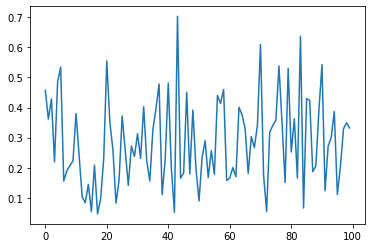

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(train_losses[900
                      :1000])

In [ ]:
len([x for x in train_iter if x[0]=='neg'])

12500

In [ ]:
model_tiny = bert.Bert({"num_layers":2, "hidden_size":384,"intermediate_size":1536,"num_heads":6,"vocab_size":28996},None)
sum([np.prod(p.shape) for p in model_tiny.parameters()])

26194374